# Make an Uplift simulation

Make a simulated population, treat 50% with marketing and 50% with nothing, learn to predict who-reacts-positively-to-marketing, output a pickle for use in `make_plots`.

* `mkt_neg` (_sleeping dogs_) - marketing is a negative, upon receipt the churn risk increases
* `bad_exp` (_lost causes_) - person had a bad experience, they're more likely to churn (regardless of marketing) 
* `mkt_pos` (_persuadable_) - marketing is a positive, upon receipt the churn risk _decreases_
* `brand_loyal` (_sure things_) - person likes the brand, they're less likely to churn (regardless of marketing)

Terms taken from "Identifying who can be saved and who will be driven away by retention activity", Radcliffe 2007: https://www.stochasticsolutions.com/pdf/SavedAndDrivenAway.pdf


In [1]:
%load_ext autoreload
%autoreload 2

import datetime
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas
from utility import summarise_groups_pretty, make_ppl, determine_churners

from utility import marketing_props, BASE_CHURN

In [2]:
# Population
TRAIN_SIZE = 100_000
# ML
TEST_SIZE = 50_000  # 0.3 # 0.3 means 30% test set size

# SIZE = 500_000
# TEST_SIZE = 100_000
VAL_SIZE = TEST_SIZE

features = ["mkt_neg", "bad_exp", "mkt_pos", "brand_loyal"]

In [3]:
# TODO uplift_test should be 1.0, not 0.999
model_type = "uplift"
ppl_train = determine_churners(
    make_ppl(TRAIN_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_train"],
)

ppl_test = determine_churners(
    make_ppl(TEST_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_test"],
)
ppl_val = determine_churners(
    make_ppl(VAL_SIZE, BASE_CHURN), marketing_prop=marketing_props[f"{model_type}_val"]
)

X_train = ppl_train[features]
X_test = ppl_test[features]
X_val = ppl_val[features]
y_train = ppl_train["will_churn"]
y_test = ppl_test["will_churn"]
y_val = ppl_val["will_churn"]

ppl = pd.concat((ppl_train, ppl_test))
assert ppl.shape[1] == ppl_train.shape[1]

ppl.sample(5)  # sample from whole population

determine_churners on 100000 rows with marketing_prop 0.50
determine_churners on 50000 rows with marketing_prop 0.50
determine_churners on 50000 rows with marketing_prop 1.00


,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
47155,1,1,0,0,0.16,0,0
45621,0,0,0,0,0.16,1,1
46172,0,0,1,0,0.21,1,1
42181,1,0,0,1,0.06,1,0
91303,0,0,0,0,0.16,1,0


In [4]:
percentiles = [0.01, 0.05, 0.5, 0.95, 0.99]
ppl_train.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.198160,0.19785,0.200290,0.202070,0.159950,0.499500,0.158990
std,0.398615,0.39838,0.400219,0.401546,0.034575,0.500002,0.365669
min,0.000000,0.00000,0.000000,0.000000,0.060000,0.000000,0.000000
1%,0.000000,0.00000,0.000000,0.000000,0.060000,0.000000,0.000000
5%,0.000000,0.00000,0.000000,0.000000,0.110000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.160000,0.000000,0.000000
95%,1.000000,1.00000,1.000000,1.000000,0.210000,1.000000,1.000000
99%,1.000000,1.00000,1.000000,1.000000,0.260000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,0.260000,1.000000,1.000000


In [5]:
ppl_test.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.199620,0.196700,0.197120,0.198580,0.159799,0.499800,0.160360
std,0.399719,0.397508,0.397828,0.398935,0.034549,0.500005,0.366943
min,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.210000,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.260000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.260000,1.000000,1.000000


In [6]:
ppl_val.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.00000
mean,0.199620,0.196700,0.197120,0.198580,0.159781,1.0,0.16014
std,0.399719,0.397508,0.397828,0.398935,0.039848,0.0,0.36674
min,0.000000,0.000000,0.000000,0.000000,0.060000,1.0,0.00000
1%,0.000000,0.000000,0.000000,0.000000,0.060000,1.0,0.00000
5%,0.000000,0.000000,0.000000,0.000000,0.110000,1.0,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.160000,1.0,0.00000
95%,1.000000,1.000000,1.000000,1.000000,0.210000,1.0,1.00000
99%,1.000000,1.000000,1.000000,1.000000,0.260000,1.0,1.00000
max,1.000000,1.000000,1.000000,1.000000,0.260000,1.0,1.00000


In [7]:
ppl.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.198647,0.197467,0.199233,0.200907,0.159900,0.499600,0.159447
std,0.398983,0.398089,0.399425,0.400680,0.034567,0.500002,0.366093
min,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.210000,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.260000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.260000,1.000000,1.000000


In [8]:
# calc nbr and percentage ppl who churn given probability estimates
# ppl["prob_churn_bin"] = pd.cut(ppl["prob_churn"], bins=10)
# display(ppl.groupby("prob_churn_bin")["will_churn"].sum())
# display(
#    ppl.groupby("prob_churn_bin")["will_churn"].sum()
#    / ppl.groupby("prob_churn_bin")["will_churn"].size()
# )
# ppl = ppl.drop(columns="prob_churn_bin")

In [9]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.11,1,0
1,0,0,0,1,0.11,1,0
2,0,0,0,0,0.16,0,0
3,0,0,1,0,0.21,1,0
4,1,1,0,0,0.16,0,0
...,...,...,...,...,...,...,...
49995,0,0,1,0,0.16,0,0
49996,0,0,0,0,0.16,1,0
49997,0,0,0,0,0.16,1,0
49998,0,0,0,0,0.16,0,0


In [10]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(
            int,
            [
                pa.Check.isin([0, 1]),
                # TODO should check no mkting for train, mkting for test
                # pa.Check(lambda s: s.mean() > 0.45),
                # pa.Check(lambda s: s.mean() < 0.55),
            ],
        ),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                # pa.Hypothesis.two_sample_ttest(
                #    sample1=1,
                #    sample2=0,
                #    groupby="mkt_neg",
                #    relationship="greater_than",
                #    alpha=0.05,
                #    equal_var=True,
                # ),
            ],
        ),
    },
    strict=True,
    ordered=False,
)
schema.validate(
    ppl,
    lazy=True,
)
schema.validate(
    ppl_val,
    lazy=True,
);

# Look at some examples of those who do or don't churn

In [11]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
21,0,1,1,1,0.21,0,1
102,1,0,1,0,0.16,1,1


In [12]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.11,1,0
1,0,0,0,1,0.11,1,0


# Start to prepare for ML

In [13]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'prob_churn',
       'gets_mkting', 'will_churn'],
      dtype='object')

In [14]:
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = (
    set(ppl.columns)
    .difference(set(features))
    .difference({"will_churn", "prob_churn", "gets_mkting"})
)

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1 / 0  # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [15]:
# ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
#    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
# )
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [16]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.4402733618167554

In [17]:
base_model = LogisticRegression
# base_model = partial(RandomForestClassifier, n_estimators=5)

## Start to prepare for dual fit

In [18]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
uplift_model = base_model
# uplift_model = LogisticRegression
# uplift_model = partial(RandomForestClassifier, n_estimators=10)
est_up_c = uplift_model()
est_up_t = uplift_model()

print(f"Building a C and T model with {est_up_c} and {est_up_t}")

mask_train_c = ppl_train["gets_mkting"] == 0
mask_train_t = ppl_train["gets_mkting"] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

# score on their sub-trained population type
mask_test_c = ppl_test["gets_mkting"] == 0
mask_test_t = ppl_test["gets_mkting"] == 1
# if we have e.g. all-get-marketing then the control group has 0 size
if mask_test_c.sum() > 0:
    up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
    print(log_loss(y_test[mask_test_c], up_c_pred_proba_pos))
else:
    up_c_pred_proba_pos = np.array([])
if mask_test_t.sum() > 0:
    up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]
    print(
        log_loss(y_test[mask_test_t], up_t_pred_proba_pos)
    )  # CHECK expect lower than control

Building a C and T model with LogisticRegression() and LogisticRegression()
0.437416469253321
0.4343219467729124


## Check C and T predictions from Uplift model

In [19]:
pd.Series(up_c_pred_proba_pos).describe()

count    25010.000000
mean         0.159612
std          0.028379
min          0.111538
25%          0.157383
50%          0.157383
75%          0.161715
max          0.219728
dtype: float64

In [20]:
pd.Series(up_t_pred_proba_pos).describe()

count    24990.000000
mean         0.158025
std          0.040804
min          0.075252
25%          0.146205
50%          0.156134
75%          0.156134
max          0.279002
dtype: float64

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [21]:
del ppl_test, ppl
del ppl_train
del X_train, X_test
del y_train, y_test

In [22]:
keys = [
    "uplift_diff_t_c",
    "up_proba_c",
    "up_proba_t",
    "dummy_proba_pos",
]

In [23]:
# NOTE we have to work off of the validation set (not test set)
# for the validation set we set _everyone_ to receive marketing, now we have to
# judge how well we can order given their characteristics

result = pd.DataFrame({"y_true": y_val})
result["dummy_proba_pos"] = est_dummy.predict_proba(X_val)[:, 1]

# score on the validation set
result["up_proba_c"] = est_up_c.predict_proba(X_val)[:, 1]
result["up_proba_t"] = est_up_t.predict_proba(X_val)[:, 1]
# if T says 90% prob churn conditional mkting, C says 10% prob churn then +80%
# if T says 10% prob churn conditional mkting, C says 90% prob churn then -80%
result["uplift_diff_t_c"] = result["up_proba_t"] - result["up_proba_c"]

for key in keys:
    assert key in result.columns

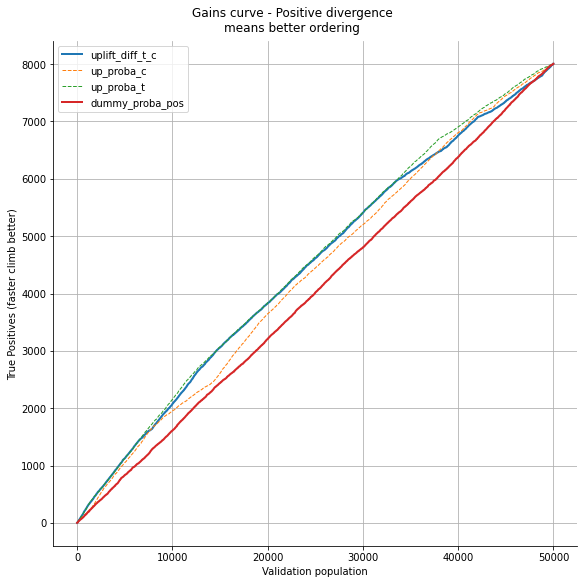

In [24]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Validation population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

<AxesSubplot:>

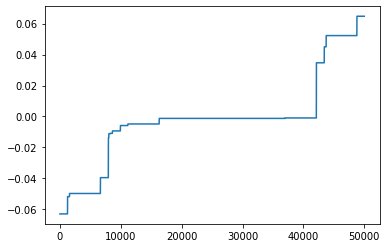

In [25]:
# sort by predicted uplift, the earliest values have lowest chance of churn if marketed at or are sure things,
# the last values have highest chance of churn if marketed at (sleeping dogs) or are lost causes
# negatives will stay, 0s can't be influenced, positives more likely to churn
result.sort_values("uplift_diff_t_c", ascending=True)["uplift_diff_t_c"].reset_index(
    drop=True
).plot()

In [26]:
test_merged = pd.merge(
    left=result,
    right=ppl_val,
    left_index=True,
    right_index=True,
    validate="one_to_one",
)
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values("prob_churn").drop(
    columns=[
        "dummy_proba_pos",
    ]
)

,y_true,up_proba_c,up_proba_t,uplift_diff_t_c,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
34909,0,0.111538,0.106697,-0.004841,1,0,0,0,0.11,1,0
14660,0,0.111538,0.106697,-0.004841,1,0,0,0,0.11,1,0
24092,0,0.111538,0.106697,-0.004841,1,0,0,0,0.11,1,0
19790,0,0.157383,0.156134,-0.001249,0,0,0,0,0.16,1,0
8804,0,0.157383,0.156134,-0.001249,0,0,0,0,0.16,1,0
34257,0,0.157383,0.156134,-0.001249,0,0,0,0,0.16,1,0
19604,0,0.157383,0.156134,-0.001249,0,0,0,0,0.16,1,0
37930,0,0.157383,0.156134,-0.001249,0,0,0,0,0.16,1,0
43525,0,0.210615,0.209652,-0.000963,0,1,0,0,0.21,1,0
34266,0,0.160278,0.212542,0.052264,0,0,1,0,0.21,1,0


In [27]:
# show bins in equal blocks
test_merged2 = test_merged.sort_values("uplift_diff_t_c", ascending=True).copy()
test_merged2 = test_merged2.reset_index(drop=True)
test_merged2["binned_index"] = pd.cut(test_merged2.index, 10)

res = test_merged2.groupby("binned_index").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
    uplift_diff_t_c=pd.NamedAgg("uplift_diff_t_c", "mean"),
)
# res

res[::-1].style.pipe(
    summarise_groups_pretty, "Feature contributions to Uplift prediction"
)

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum,up_proba_c_mean,up_proba_t_mean,uplift_diff_t_c
binned_index,,,,,,,,,
"(44999.1, 49999.0]",5000,0.225600,0,1220,0,5000,0.173445,0.228759,0.055314
"(39999.2, 44999.1]",5000,0.190200,0,2434,1607,2878,0.169241,0.193909,0.024667
"(34999.3, 39999.2]",5000,0.190600,0,3020,0,0,0.189535,0.188459,-0.001076
"(29999.4, 34999.3]",5000,0.157800,0,0,0,0,0.157383,0.156134,-0.001249
"(24999.5, 29999.4]",5000,0.155200,0,0,0,0,0.157383,0.156134,-0.001249
"(19999.6, 24999.5]",5000,0.155600,0,0,0,0,0.157383,0.156134,-0.001249
"(14999.7, 19999.6]",5000,0.150800,0,0,1300,0,0.145464,0.143281,-0.002183
"(9999.8, 14999.7]",5000,0.126800,0,1149,5000,0,0.120850,0.115776,-0.005074
"(4999.9, 9999.8]",5000,0.121200,4929,443,1749,1978,0.150845,0.120106,-0.030739


In [28]:
test_merged["uplift_diff_t_c_bins"] = pd.cut(test_merged["uplift_diff_t_c"], 4)

# test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 3)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

In [29]:
res = test_merged.groupby("uplift_diff_t_c_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
)
# res

# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [30]:
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
display(
    "Negative uplift_diff_t_c_bins will respond to marketing, positives respond worse when marketed at"
)
res[::-1].style.pipe(
    summarise_groups_pretty, "Feature contributions to Uplift prediction"
)

'Base churn rate for all is circa 16.0%'

'Negative uplift_diff_t_c_bins will respond to marketing, positives respond worse when marketed at'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum,up_proba_c_mean,up_proba_t_mean
uplift_diff_t_c_bins,,,,,,,,
"(0.0328, 0.0648]",7878,0.208175,0,1532,1607,7878,0.160765,0.211787
"(0.000895, 0.0328]",0,nan,0,0,0,0,nan,nan
"(-0.031, 0.000895]",34171,0.159024,1978,6734,6742,1978,0.158768,0.156349
"(-0.0631, -0.031]",7951,0.117344,7951,1569,1632,0,0.162276,0.112041


# Estimate value to business 

In [31]:
df_comparison = test_merged.sort_values(
    "uplift_diff_t_c", ascending=True
).copy()  # most likely needing marketing first
df_comparison = df_comparison[["uplift_diff_t_c", "will_churn"]].rename(
    columns={"will_churn": "uplift_will_churn"}
)
df_comparison = df_comparison.reset_index(drop=True)

OUTFILE = "df_comparison_uplift.pickle"
print(f"Writing to {OUTFILE} with {df_comparison.columns}")
df_comparison.to_pickle(OUTFILE)
# f_costing.plot(kind='line', y='value_generated_cumsum');

Writing to df_comparison_uplift.pickle with Index(['uplift_diff_t_c', 'uplift_will_churn'], dtype='object')


In [32]:
datetime.datetime.now()

datetime.datetime(2022, 2, 18, 16, 25, 14, 834403)